Gradient ascent to visualize the effect of the metrics

In [18]:
import torch
import torchvision
from torchvision.datasets import CIFAR10

import matplotlib as mpl

from labproject.embeddings import EmbeddingNet, FIDEmbeddingNet
from labproject.external.inception_v3 import InceptionV3, get_inception_v3_activations

In [43]:
dataset = CIFAR10('../../data', train=True, download=True)

In [227]:
def sample_from_class(dataset, class_idx, n_samples=16, to_tensor=True):
    idxs = torch.where(torch.tensor(dataset.targets) == class_idx)[0]
    idxs = idxs[torch.randperm(len(idxs))[:n_samples]]
    if to_tensor:
        return torch.stack([torchvision.transforms.ToTensor()(dataset[idx][0]) for idx in idxs])
    return [dataset[idx][0] for idx in idxs]

In [233]:
class TwoSampleSet(torch.utils.data.Dataset):

    def __init__(self, dataset, class1, class2, n_samples=16, batch_size=4, two_requires_grad=True):
        self.class1 = sample_from_class(dataset, class1, n_samples)
        self.class2 = sample_from_class(dataset, class2, n_samples)
        self.class2.requires_grad = two_requires_grad
        self.n_samples = n_samples
        self.batch_size = batch_size

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.class1[idx], self.class2[idx].clip(0, 1)

    def plot_grid(self, which=1, width=4, height=4, figsize=[4, 4]):

        if which == 1:
            data = twosampleset.class1
        elif which == 2:
            data = twosampleset.class2

        fig, ax = plt.subplots(width, height, figsize = figsize)

        for idx, (i, j) in enumerate(product(range(width), range(height))):
            try:
                img = data[idx]
            except IndexError:
                break
            if isinstance(img, torch.Tensor):
                img = img.detach().numpy().transpose((1, 2, 0)).clip(0, 1)
            ax[i, j].imshow(img)
            ax[i, j].set_axis_off()
        plt.subplots_adjust(wspace=0.1, hspace=0)

In [234]:
twosampleset = TwoSampleSet(dataset, 0, 1)

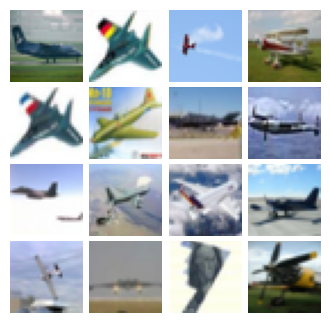

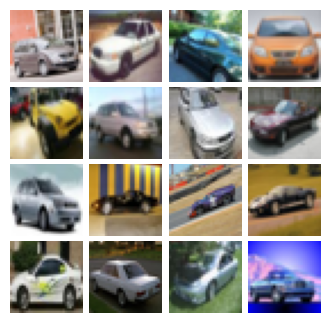

In [235]:
twosampleset.plot_grid(1, width=4, height=4)
twosampleset.plot_grid(2, width=4, height=4)

In [236]:
dataloader = torch.utils.data.DataLoader(twosampleset, batch_size=16, shuffle=True)

In [237]:
embedding_net = InceptionV3()
def get_inception_v3_activations_with_grad(model, images):
    """
    Get activations from the InceptionV3 model for the given images.

    Args:
        model (torch.nn.Module): The InceptionV3 model.
        images (torch.Tensor): The images for which to compute the activations.

    Returns:
        list: A list of torch.Tensor containing the activations from the model.
    """
    model.eval()
    pred = model(images)[0]
    pred = pred.squeeze(3).squeeze(2).cpu()
    return pred

In [238]:
optim = torch.optim.Adam([dataloader.dataset.class2], lr=0.1)

In [239]:
metrics.gaussian_squared_wasserstein.gaussian_squared_w2_distance(activations1, activations2)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [240]:
n_epochs = 5
losses = []

for epochs in range(n_epochs):
    for batch_class1, batch_class2 in dataloader:
        optim.zero_grad()
        activations1 = get_inception_v3_activations_with_grad(embedding_net, batch_class1)
        activations2 = get_inception_v3_activations_with_grad(embedding_net, batch_class2)
        loss = metrics.sliced_wasserstein.sliced_wasserstein_distance(activations1, activations2)
        loss.backward()
        losses.append(loss.item())
        optim.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

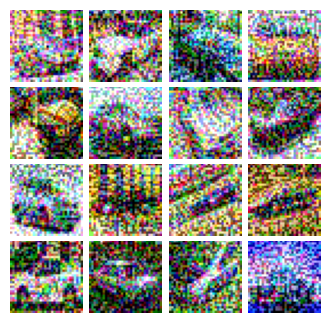

In [241]:
twosampleset.plot_grid(2, width=4, height=4)